In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    CLIPModel,
    CLIPProcessor,
    XLMRobertaModel,  # Changed from BertModel
    XLMRobertaTokenizer,  # Changed from BertTokenizer
    get_linear_schedule_with_warmup
)
import albumentations as A
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/memo_3/memotion3/memotion3/train.csv')

In [4]:
train_df['overall'] = train_df['overall'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

/tmp/ipython-input-3740866416.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['overall'] = train_df['overall'].replace({


In [5]:
val_df = pd.read_csv('/content/drive/MyDrive/memo_3/val.csv')

In [6]:
val_df['overall'] = val_df['overall'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

/tmp/ipython-input-2159871312.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['overall'] = val_df['overall'].replace({


In [ ]:
!pip install text_hammer

In [8]:
import text_hammer as th

In [9]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; we'll be -> we will be
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

  return df

CPU times: user 371 µs, sys: 0 ns, total: 371 µs
Wall time: 350 µs


In [ ]:
train_dataset = text_preprocessing(train_df, 'ocr')
val_dataset = text_preprocessing(val_df, 'ocr')

In [11]:
# ===================== Dataset Class =====================
class MemeDataset(Dataset):
    def __init__(self, images, captions, sentiments, tokenizer, image_transforms, image_dir):
        self.images = images
        self.captions = captions
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        caption = self.captions[idx]
        sentiment = self.sentiments[idx]

        # Load and preprocess image
        try:
            image = Image.open(image_path).convert('RGB')
            image = np.array(image)
        except Exception as e:
            image = np.full((224, 224, 3), 128, dtype=np.uint8)

        # Apply transforms
        image = self.image_transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()

        # Ensure caption is a valid string
        if not isinstance(caption, str):
            caption = str(caption) if caption else "empty caption"
        if isinstance(caption, list):
            caption = ' '.join(caption)
        if not caption or caption.strip() == '':
            caption = "empty caption"

        # Encode caption with XLM-RoBERTa tokenizer
        # Note: XLM-RoBERTa uses max_length=512 by default (vs BERT's 512)
        encoded_caption = self.tokenizer(
            caption,
            return_tensors="pt",
            padding='max_length',
            truncation=True,
            max_length=128  # Can be longer for Hinglish text
        )
        input_ids = encoded_caption['input_ids'].squeeze()
        attention_mask = encoded_caption['attention_mask'].squeeze()

        sentiment_class = torch.tensor(sentiment, dtype=torch.long)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'sentiment': sentiment_class
        }


# ===================== Cross-Attention Fusion Module =====================
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super(CrossAttentionFusion, self).__init__()

        # Bidirectional cross-attention
        self.text_to_image = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )
        self.image_to_text = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )

        # Feed-forward networks
        self.ffn_text = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )

        self.ffn_image = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )

        # Layer normalization
        self.norm_text_1 = nn.LayerNorm(embed_dim)
        self.norm_text_2 = nn.LayerNorm(embed_dim)
        self.norm_image_1 = nn.LayerNorm(embed_dim)
        self.norm_image_2 = nn.LayerNorm(embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, image_feats, text_feats):
        # Text attends to image
        text_attended, _ = self.text_to_image(
            query=text_feats, key=image_feats, value=image_feats
        )
        text_feats = self.norm_text_1(text_feats + self.dropout(text_attended))
        text_feats = self.norm_text_2(text_feats + self.ffn_text(text_feats))

        # Image attends to text
        image_attended, _ = self.image_to_text(
            query=image_feats, key=text_feats, value=text_feats
        )
        image_feats = self.norm_image_1(image_feats + self.dropout(image_attended))
        image_feats = self.norm_image_2(image_feats + self.ffn_image(image_feats))

        # Pool and concatenate
        image_pooled = image_feats.mean(dim=1)
        text_pooled = text_feats.mean(dim=1)
        fused_features = torch.cat([image_pooled, text_pooled], dim=1)

        return fused_features, image_pooled, text_pooled


# ===================== Enhanced Loss Function with Class Weights =====================
class EnhancedLoss(nn.Module):
    def __init__(self, contrastive_weight=0.04, temperature=0.07, class_weights=None):
        super(EnhancedLoss, self).__init__()
        # Use weighted cross entropy if class imbalance exists
        if class_weights is not None:
            self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.ce_loss = nn.CrossEntropyLoss()
        self.contrastive_weight = contrastive_weight  # Reduced from 0.1 to 0.05
        self.temperature = temperature

    def forward(self, logits, labels, image_feats, text_feats):
        ce_loss = self.ce_loss(logits, labels)

        # Contrastive alignment
        image_feats_norm = F.normalize(image_feats, dim=-1)
        text_feats_norm = F.normalize(text_feats, dim=-1)
        similarity = torch.matmul(image_feats_norm, text_feats_norm.T) / self.temperature

        batch_size = image_feats.size(0)
        labels_contrastive = torch.arange(batch_size).to(image_feats.device)

        contrastive_loss = (
            F.cross_entropy(similarity, labels_contrastive) +
            F.cross_entropy(similarity.T, labels_contrastive)
        ) / 2

        total_loss = ce_loss + self.contrastive_weight * contrastive_loss
        return total_loss, ce_loss, contrastive_loss


# ===================== Main Model with XLM-RoBERTa =====================
class CustomCLIPXLMRoBERTaModel(nn.Module):
    """
    CLIP + XLM-RoBERTa model for Hinglish meme sentiment classification.
    """
    def __init__(self, clip_model, xlm_roberta_model):
        super(CustomCLIPXLMRoBERTaModel, self).__init__()
        self.clip_model = clip_model
        self.xlm_roberta_model = xlm_roberta_model

        # Make models trainable
        for param in self.clip_model.parameters():
            param.requires_grad = True
        for param in self.xlm_roberta_model.parameters():
            param.requires_grad = True

        # Project CLIP vision features to XLM-RoBERTa dimension (768)
        self.image_proj = nn.Sequential(
            nn.Linear(768, 768),
            nn.LayerNorm(768),
            nn.GELU()
        )

        # Cross-attention fusion
        self.cross_fusion = CrossAttentionFusion(embed_dim=768, num_heads=8, dropout=0.1)

        # 4-layer MLP classifier with increased dropout
        self.classifier = nn.Sequential(
            # Layer 1
            nn.Linear(768 * 2, 768),
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(0.2),  # Increased dropout

            # Layer 2
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            # Layer 3
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2),

            # Layer 4
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.1),

            # Output layer
            nn.Linear(128, 3)
        )

    def forward(self, image, input_ids, attention_mask):
        # Extract CLIP vision features
        vision_outputs = self.clip_model.vision_model(pixel_values=image)
        image_features = vision_outputs.last_hidden_state  # [B, 50, 768]
        image_features = self.image_proj(image_features)

        # Extract XLM-RoBERTa text features
        xlm_output = self.xlm_roberta_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        text_features = xlm_output.last_hidden_state  # [B, seq_len, 768]

        # Cross-attention fusion
        fused_features, image_pooled, text_pooled = self.cross_fusion(
            image_features, text_features
        )

        # Classification
        logits = self.classifier(fused_features)
        return logits, image_pooled, text_pooled


# ===================== Utility Classes =====================
class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


# ===================== Training Function =====================
def train_epoch(model, train_loader, optimizer, scheduler, device, criterion, scaler=None):
    model.train()
    loss_meter = AvgMeter()
    ce_loss_meter = AvgMeter()
    contrastive_loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    tqdm_object = tqdm(train_loader, total=len(train_loader))

    for batch in tqdm_object:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()

        if scaler is not None:
            with autocast():
                logits, image_feats, text_feats = model(images, input_ids, attention_mask)
                loss, ce_loss, contrastive_loss = criterion(
                    logits, sentiments, image_feats, text_feats
                )

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits, image_feats, text_feats = model(images, input_ids, attention_mask)
            loss, ce_loss, contrastive_loss = criterion(
                logits, sentiments, image_feats, text_feats
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)
        ce_loss_meter.update(ce_loss.item(), count)
        contrastive_loss_meter.update(contrastive_loss.item(), count)

        preds = logits.argmax(dim=1)
        correct_predictions += (preds == sentiments).sum().item()
        total_predictions += sentiments.size(0)

        tqdm_object.set_postfix(
            train_loss=loss_meter.avg,
            ce_loss=ce_loss_meter.avg,
            contrast_loss=contrastive_loss_meter.avg,
            lr=get_lr(optimizer)
        )

    accuracy = correct_predictions / total_predictions
    return loss_meter, ce_loss_meter, contrastive_loss_meter, accuracy


# ===================== Evaluation Function =====================
def evaluate(model, data_loader, device, criterion):
    model.eval()
    predictions, true_labels = [], []
    loss_meter = AvgMeter()
    ce_loss_meter = AvgMeter()
    contrastive_loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            logits, image_feats, text_feats = model(images, input_ids, attention_mask)
            loss, ce_loss, contrastive_loss = criterion(
                logits, sentiments, image_feats, text_feats
            )

            loss_meter.update(loss.item(), len(images))
            ce_loss_meter.update(ce_loss.item(), len(images))
            contrastive_loss_meter.update(contrastive_loss.item(), len(images))

            preds = logits.argmax(dim=1)
            correct_predictions += (preds == sentiments).sum().item()
            total_predictions += sentiments.size(0)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(sentiments.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    return predictions, true_labels, loss_meter.avg, ce_loss_meter.avg, contrastive_loss_meter.avg, accuracy


# ===================== Visualization Functions =====================
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
    ax2.plot(val_accuracies, label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history_xlm.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(true_labels, predictions, class_names=['Negative', 'Neutral', 'Positive']):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - XLM-RoBERTa')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_xlm.png', dpi=300, bbox_inches='tight')
    plt.show()


# ===================== Main Training Script =====================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Data augmentation
train_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Load models
print("Loading CLIP and XLM-RoBERTa models...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Load XLM-RoBERTa (base model recommended for balance of performance and speed)
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
xlm_model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

print("✓ Models loaded successfully!")
print(f"  CLIP: {sum(p.numel() for p in clip_model.parameters()):,} parameters")
print(f"  XLM-RoBERTa: {sum(p.numel() for p in xlm_model.parameters()):,} parameters")

# Create model
model = CustomCLIPXLMRoBERTaModel(clip_model, xlm_model)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Dataset paths
train_image_dir = '/content/drive/MyDrive/memo_3/trainImages/trainImages'
val_image_dir = '/content/drive/MyDrive/memo_3/valImages/valImages'

# Create datasets
train_dataset = MemeDataset(
    images=train_df['image_url'].tolist(),
    captions=train_df['ocr'].tolist(),
    sentiments=train_df['overall'].tolist(),
    tokenizer=xlm_tokenizer,  # Using XLM-RoBERTa tokenizer
    image_transforms=train_image_transforms,
    image_dir=train_image_dir
)

val_dataset = MemeDataset(
    images=val_df['image_url'].tolist(),
    captions=val_df['ocr'].tolist(),
    sentiments=val_df['overall'].tolist(),
    tokenizer=xlm_tokenizer,  # Using XLM-RoBERTa tokenizer
    image_transforms=val_image_transforms,
    image_dir=val_image_dir
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# CRITICAL: Check class distribution and compute class weights
print("\n" + "="*70)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*70)

train_class_counts = train_df['overall'].value_counts().sort_index()
val_class_counts = val_df['overall'].value_counts().sort_index()

print("\nTraining Set:")
for class_idx in range(3):
    count = train_class_counts.get(class_idx, 0)
    percentage = (count / len(train_df)) * 100
    print(f"  Class {class_idx}: {count:,} samples ({percentage:.2f}%)")

print("\nValidation Set:")
for class_idx in range(3):
    count = val_class_counts.get(class_idx, 0)
    percentage = (count / len(val_df)) * 100
    print(f"  Class {class_idx}: {count:,} samples ({percentage:.2f}%)")

# Compute class weights (inverse frequency)
class_counts = torch.tensor([train_class_counts.get(i, 1) for i in range(3)], dtype=torch.float32)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * 3  # Normalize
class_weights = class_weights.to(device)

print(f"\nComputed Class Weights: {class_weights.cpu().numpy()}")
print("="*70)

# Optimizer with HIGHER learning rates
optimizer = torch.optim.AdamW([
    {'params': model.clip_model.parameters(), 'lr': 2e-6},  # Increased from 5e-7
    {'params': model.xlm_roberta_model.parameters(), 'lr': 2e-6},  # Increased from 5e-7
    {'params': model.image_proj.parameters(), 'lr': 5e-4},  # Increased from 1e-4
    {'params': model.cross_fusion.parameters(), 'lr': 5e-4},  # Increased from 1e-4
    {'params': model.classifier.parameters(), 'lr': 5e-4}  # Increased from 1e-4
], weight_decay=1e-4)

num_epochs = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_loader) * 3,
    num_training_steps=len(train_loader) * num_epochs
)

# Loss function with class weights and reduced contrastive weight
criterion = EnhancedLoss(
    contrastive_weight=0.04,  # Reduced from 0.1
    temperature=0.07,
    class_weights=class_weights  # Add class weights
)
scaler = GradScaler() if device == 'cuda' else None

# Training tracking
BEST_MODEL_PATH = 'best_model_xlm.pth'
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

print("\n" + "="*70)
print("STARTING TRAINING WITH CLIP + XLM-RoBERTa")
print("="*70)

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*50}")

    # Train
    train_loss, train_ce, train_contrast, train_accuracy = train_epoch(
        model, train_loader, optimizer, scheduler, device, criterion, scaler
    )

    # Validate
    val_predictions, val_true_labels, val_loss, val_ce, val_contrast, val_accuracy = evaluate(
        model, val_loader, device, criterion
    )

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
        }, BEST_MODEL_PATH)
        print(f"✓ Best model saved with validation accuracy: {val_accuracy:.4f}")

    # Store metrics
    train_losses.append(train_loss.avg)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss.avg:.4f} (CE: {train_ce.avg:.4f}, Contrast: {train_contrast.avg:.4f})")
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss: {val_loss:.4f} (CE: {val_ce:.4f}, Contrast: {val_contrast:.4f})")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Best Val Accuracy: {best_val_accuracy:.4f}")

# Load best model
print(f"\nLoading best model with validation accuracy: {best_val_accuracy:.4f}")
checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

# Final evaluation
print("\nFinal evaluation:")
val_predictions, val_true_labels, _, _, _, final_accuracy = evaluate(
    model, val_loader, device, criterion
)

f1_macro = f1_score(val_true_labels, val_predictions, average='macro')
f1_weighted = f1_score(val_true_labels, val_predictions, average='weighted')

print(f"\n{'='*70}")
print("FINAL RESULTS - CLIP + XLM-RoBERTa")
print(f"{'='*70}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print(f"F1-Score (Macro):          {f1_macro:.4f}")
print(f"F1-Score (Weighted):       {f1_weighted:.4f}")
print(f"{'='*70}")

print("\nClassification Report:")
print(classification_report(
    val_true_labels,
    val_predictions,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4
))

# Plot results
# plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
# plot_confusion_matrix(val_true_labels, val_predictions)

print("\nTraining complete!")
print(f"Best model saved at: {BEST_MODEL_PATH}")

Using device: cuda
Loading CLIP and XLM-RoBERTa models...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-622753432.py:403: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ Models loaded successfully!
  CLIP: 151,277,313 parameters
  XLM-RoBERTa: 278,043,648 parameters


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-622753432.py:512: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device == 'cuda' else None



Model Statistics:
  Total parameters:     445,830,916
  Trainable parameters: 445,830,916

CLASS DISTRIBUTION ANALYSIS

Training Set:
  Class 0: 1,755 samples (25.07%)
  Class 1: 2,970 samples (42.43%)
  Class 2: 2,275 samples (32.50%)

Validation Set:
  Class 0: 580 samples (38.69%)
  Class 1: 579 samples (38.63%)
  Class 2: 340 samples (22.68%)

Computed Class Weights: [1.2699286  0.75041234 0.9796592 ]

STARTING TRAINING WITH CLIP + XLM-RoBERTa

Epoch 1/10


  0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipython-input-622753432.py:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 219/219 [01:36<00:00,  2.27it/s, ce_loss=1.12, contrast_loss=3.07, lr=6.67e-7, train_loss=1.25]


✓ Best model saved with validation accuracy: 0.2268

Epoch 1 Summary:
  Train Loss: 1.2475 (CE: 1.1247, Contrast: 3.0699)
  Train Accuracy: 0.3263
  Val Loss: 1.2810 (CE: 1.1447, Contrast: 3.4088)
  Val Accuracy: 0.2268
  Best Val Accuracy: 0.2268

Epoch 2/10


100%|██████████| 219/219 [01:35<00:00,  2.30it/s, ce_loss=1.11, contrast_loss=1.28, lr=1.33e-6, train_loss=1.16]


✓ Best model saved with validation accuracy: 0.3756

Epoch 2 Summary:
  Train Loss: 1.1599 (CE: 1.1088, Contrast: 1.2779)
  Train Accuracy: 0.3364
  Val Loss: 1.1728 (CE: 1.0888, Contrast: 2.0990)
  Val Accuracy: 0.3756
  Best Val Accuracy: 0.3756

Epoch 3/10


100%|██████████| 219/219 [01:35<00:00,  2.29it/s, ce_loss=1.1, contrast_loss=0.626, lr=2e-6, train_loss=1.13]


✓ Best model saved with validation accuracy: 0.3816

Epoch 3 Summary:
  Train Loss: 1.1292 (CE: 1.1041, Contrast: 0.6256)
  Train Accuracy: 0.3400
  Val Loss: 1.1636 (CE: 1.0931, Contrast: 1.7641)
  Val Accuracy: 0.3816
  Best Val Accuracy: 0.3816

Epoch 4/10


100%|██████████| 219/219 [01:35<00:00,  2.29it/s, ce_loss=1.1, contrast_loss=0.482, lr=1.71e-6, train_loss=1.12]



Epoch 4 Summary:
  Train Loss: 1.1200 (CE: 1.1007, Contrast: 0.4819)
  Train Accuracy: 0.3599
  Val Loss: 1.1629 (CE: 1.1052, Contrast: 1.4446)
  Val Accuracy: 0.3075
  Best Val Accuracy: 0.3816

Epoch 5/10


100%|██████████| 219/219 [01:35<00:00,  2.30it/s, ce_loss=1.09, contrast_loss=0.396, lr=1.43e-6, train_loss=1.11]



Epoch 5 Summary:
  Train Loss: 1.1099 (CE: 1.0941, Contrast: 0.3956)
  Train Accuracy: 0.3574
  Val Loss: 1.1690 (CE: 1.1195, Contrast: 1.2380)
  Val Accuracy: 0.3195
  Best Val Accuracy: 0.3816

Epoch 6/10


100%|██████████| 219/219 [01:35<00:00,  2.29it/s, ce_loss=1.08, contrast_loss=0.338, lr=1.14e-6, train_loss=1.1]



Epoch 6 Summary:
  Train Loss: 1.0974 (CE: 1.0839, Contrast: 0.3382)
  Train Accuracy: 0.3861
  Val Loss: 1.1615 (CE: 1.1149, Contrast: 1.1641)
  Val Accuracy: 0.3336
  Best Val Accuracy: 0.3816

Epoch 7/10


100%|██████████| 219/219 [01:35<00:00,  2.29it/s, ce_loss=1.07, contrast_loss=0.26, lr=8.57e-7, train_loss=1.08]



Epoch 7 Summary:
  Train Loss: 1.0831 (CE: 1.0727, Contrast: 0.2602)
  Train Accuracy: 0.3940
  Val Loss: 1.1763 (CE: 1.1368, Contrast: 0.9882)
  Val Accuracy: 0.3716
  Best Val Accuracy: 0.3816

Epoch 8/10


100%|██████████| 219/219 [01:35<00:00,  2.28it/s, ce_loss=1.06, contrast_loss=0.225, lr=5.71e-7, train_loss=1.07]



Epoch 8 Summary:
  Train Loss: 1.0715 (CE: 1.0625, Contrast: 0.2250)
  Train Accuracy: 0.4166
  Val Loss: 1.1597 (CE: 1.1279, Contrast: 0.7964)
  Val Accuracy: 0.3582
  Best Val Accuracy: 0.3816

Epoch 9/10


100%|██████████| 219/219 [01:35<00:00,  2.29it/s, ce_loss=1.06, contrast_loss=0.17, lr=2.86e-7, train_loss=1.07]



Epoch 9 Summary:
  Train Loss: 1.0700 (CE: 1.0632, Contrast: 0.1704)
  Train Accuracy: 0.4146
  Val Loss: 1.1721 (CE: 1.1423, Contrast: 0.7440)
  Val Accuracy: 0.3489
  Best Val Accuracy: 0.3816

Epoch 10/10


100%|██████████| 219/219 [01:35<00:00,  2.29it/s, ce_loss=1.06, contrast_loss=0.148, lr=0, train_loss=1.06]



Epoch 10 Summary:
  Train Loss: 1.0616 (CE: 1.0557, Contrast: 0.1484)
  Train Accuracy: 0.4251
  Val Loss: 1.1571 (CE: 1.1276, Contrast: 0.7360)
  Val Accuracy: 0.3622
  Best Val Accuracy: 0.3816

Loading best model with validation accuracy: 0.3816

Final evaluation:

FINAL RESULTS - CLIP + XLM-RoBERTa
Final Validation Accuracy: 0.3816
F1-Score (Macro):          0.2957
F1-Score (Weighted):       0.3313

Classification Report:
              precision    recall  f1-score   support

    Negative     0.4103    0.2603    0.3186       580
     Neutral     0.3834    0.7012    0.4957       579
    Positive     0.2083    0.0441    0.0728       340

    accuracy                         0.3816      1499
   macro avg     0.3340    0.3352    0.2957      1499
weighted avg     0.3541    0.3816    0.3313      1499


Training complete!
Best model saved at: best_model_xlm.pth


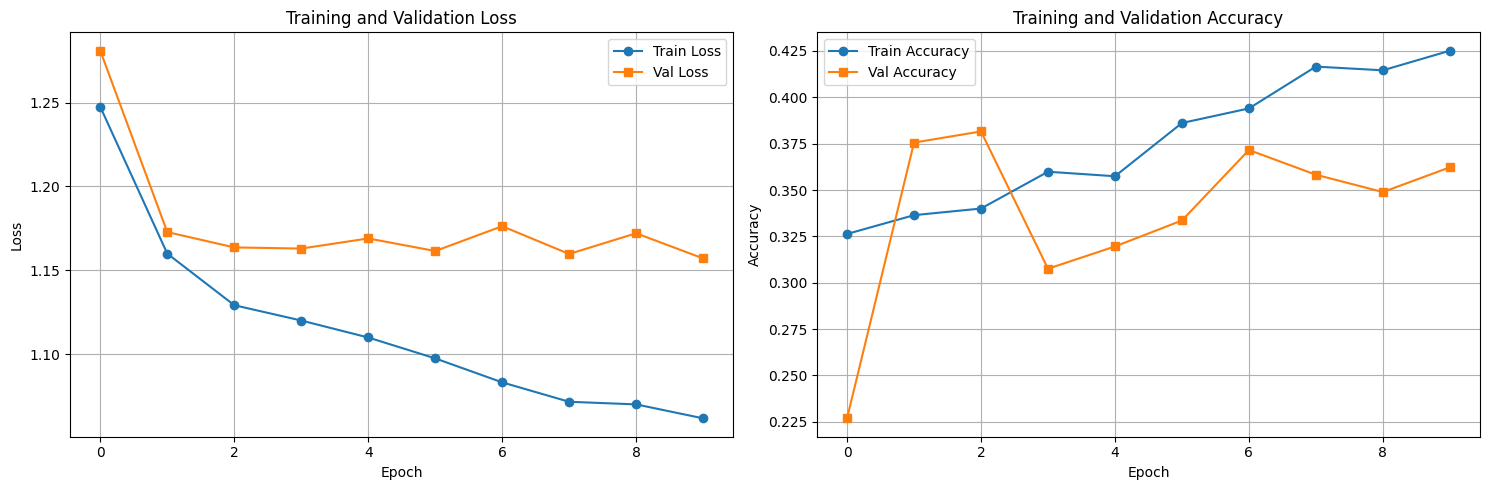

In [12]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)